#Waymo Open Dataset 3D Semantic Segmentation Tutorial

- Website: https://waymo.com/open
- GitHub: https://github.com/waymo-research/waymo-open-dataset

This tutorial demonstrates how to decode and interpret the 3D semantic segmentation labels. Visit the [Waymo Open Dataset Website](https://waymo.com/open) to download the full dataset.

To use, open this notebook in [Colab](https://colab.research.google.com).

Uncheck the box "Reset all runtimes before running" if you run this colab directly from the remote kernel. Alternatively, you can make a copy before trying to run it by following "File > Save copy in Drive ...".



# Package Installation

In [ ]:
!pip3 install waymo-open-dataset-tf-2-12-0==1.6.4

# Imports and global definitions

In [1]:
# Data location. Please edit.

# A tfrecord containing tf.Example protos as downloaded from the Waymo dataset
# webpage.

# Replace this path with your own tfrecords.
FILENAME = '/media/mike/MainDrive/Documents/data/perception_1.4.2/training/segment-10096619443888687526_2820_000_2840_000_with_camera_labels.tfrecord'

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import numpy as np

tf.enable_eager_execution()

from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset.protos import segmentation_metrics_pb2
from waymo_open_dataset.protos import segmentation_submission_pb2

2024-05-27 15:23:14.729334: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 15:23:14.940484: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 15:23:14.941523: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 15:23:15.795009: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Read 3D semantic segmentation labels from Frame proto
 Note that only a subset of the frames have 3d semseg labels.

In [3]:
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    if frame.lasers[0].ri_return1.segmentation_label_compressed:
      break

2024-05-27 15:23:17.232826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 15:23:17.248652: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-05-27 15:23:17.300088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Pla

In [4]:
print(frame.context.name)
print(frame.context.stats)
print(frame.context)

10096619443888687526_2820_000_2840_000
laser_object_counts {
  type: TYPE_VEHICLE
  count: 12
}
laser_object_counts {
  type: TYPE_PEDESTRIAN
  count: 3
}
laser_object_counts {
  type: TYPE_SIGN
  count: 4
}
time_of_day: "Day"
location: "location_sf"
weather: "sunny"
camera_object_counts {
  type: TYPE_VEHICLE
  count: 9
}
camera_object_counts {
  type: TYPE_PEDESTRIAN
  count: 1
}

name: "10096619443888687526_2820_000_2840_000"
camera_calibrations {
  name: FRONT
  intrinsic: 2060.1425931120934
  intrinsic: 2060.1425931120934
  intrinsic: 975.5965057143899
  intrinsic: 630.853334844486
  intrinsic: 0.04141289654300018
  intrinsic: -0.33489740041263666
  intrinsic: 0.0005022866894809016
  intrinsic: -0.0009337226533304631
  intrinsic: 0.0
  extrinsic {
    transform: 0.9999790376291948
    transform: 0.0045643569339703614
    transform: -0.004592488211072773
    transform: 1.5393679168564702
    transform: -0.004561049760530192
    transform: 0.9999893316554864
    transform: 0.0007303

In [5]:
(range_images, camera_projections, segmentation_labels,
 range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(
    frame)

In [6]:
print(segmentation_labels[open_dataset.LaserName.TOP][0].shape.dims)

[64, 2650, 2]


# Visualize Segmentation Labels in Range Images

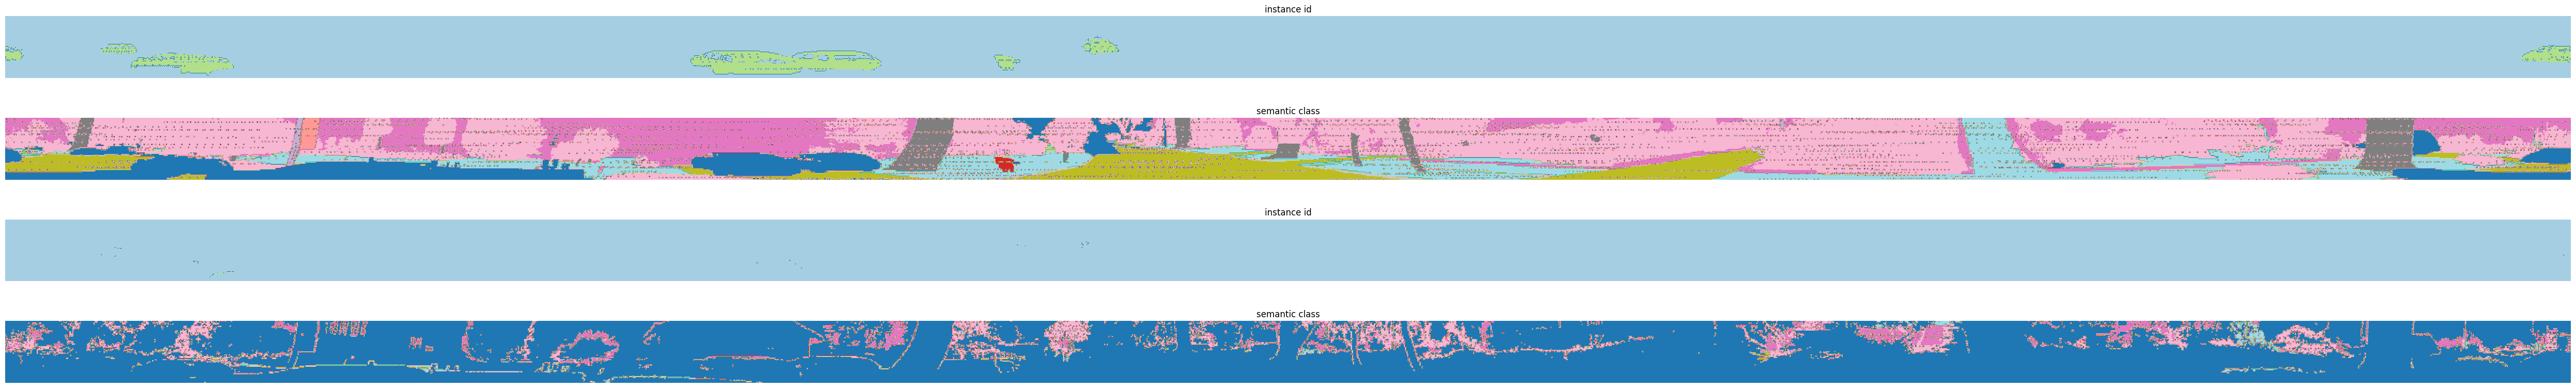

In [8]:
plt.figure(figsize=(64, 20))
def plot_range_image_helper(data, name, layout, vmin = 0, vmax=1, cmap='gray'):
  """Plots range image.

  Args:
    data: range image data
    name: the image title
    layout: plt layout
    vmin: minimum value of the passed data
    vmax: maximum value of the passed data
    cmap: color map
  """
  plt.subplot(*layout)
  plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.title(name)
  plt.grid(False)
  plt.axis('off')

def get_semseg_label_image(laser_name, return_index):
  """Returns semseg label image given a laser name and its return index."""
  return segmentation_labels[laser_name][return_index]

def show_semseg_label_image(semseg_label_image, layout_index_start = 1):
  """Shows range image.

  Args:
    show_semseg_label_image: the semseg label data of type MatrixInt32.
    layout_index_start: layout offset
  """
  semseg_label_image_tensor = tf.convert_to_tensor(semseg_label_image.data)
  semseg_label_image_tensor = tf.reshape(
      semseg_label_image_tensor, semseg_label_image.shape.dims)
  instance_id_image = semseg_label_image_tensor[...,0] 
  semantic_class_image = semseg_label_image_tensor[...,1]
  plot_range_image_helper(instance_id_image.numpy(), 'instance id',
                   [8, 1, layout_index_start], vmin=-1, vmax=200, cmap='Paired')
  plot_range_image_helper(semantic_class_image.numpy(), 'semantic class',
                   [8, 1, layout_index_start + 1], vmin=0, vmax=22, cmap='tab20')

frame.lasers.sort(key=lambda laser: laser.name)
show_semseg_label_image(get_semseg_label_image(open_dataset.LaserName.TOP, 0), 1)
show_semseg_label_image(get_semseg_label_image(open_dataset.LaserName.TOP, 1), 3)

# Point Cloud Conversion and Visualization

In [11]:
def convert_range_image_to_point_cloud_labels(frame,
                                              range_images,
                                              segmentation_labels,
                                              ri_index=0):
  """Convert segmentation labels from range images to point clouds.

  Args:
    frame: open dataset frame
    range_images: A dict of {laser_name, [range_image_first_return,
       range_image_second_return]}.
    segmentation_labels: A dict of {laser_name, [range_image_first_return,
       range_image_second_return]}.
    ri_index: 0 for the first return, 1 for the second return.

  Returns:
    point_labels: {[N, 2]} list of 3d lidar points's segmentation labels. 0 for
      points that are not labeled.
  """
  calibrations = sorted(frame.context.laser_calibrations, key=lambda c: c.name)
  point_labels = []
  for c in calibrations:
    range_image = range_images[c.name][ri_index]
    range_image_tensor = tf.reshape(
        tf.convert_to_tensor(range_image.data), range_image.shape.dims)
    range_image_mask = range_image_tensor[..., 0] > 0

    if c.name in segmentation_labels:
      sl = segmentation_labels[c.name][ri_index]
      sl_tensor = tf.reshape(tf.convert_to_tensor(sl.data), sl.shape.dims)
      sl_points_tensor = tf.gather_nd(sl_tensor, tf.where(range_image_mask))
    else:
      num_valid_point = tf.math.reduce_sum(tf.cast(range_image_mask, tf.int32))
      sl_points_tensor = tf.zeros([num_valid_point, 2], dtype=tf.int32)
      
    point_labels.append(sl_points_tensor.numpy())
  return point_labels

In [9]:
points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame, range_images, camera_projections, range_image_top_pose, keep_polar_features=True)
points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
    frame, range_images, camera_projections, range_image_top_pose, ri_index=1)

In [12]:
point_labels = convert_range_image_to_point_cloud_labels(
    frame, range_images, segmentation_labels)
point_labels_ri2 = convert_range_image_to_point_cloud_labels(
    frame, range_images, segmentation_labels, ri_index=1)

In [13]:
# 3d points in vehicle frame.
POINTCLOUD_X_INDEX = 3
POINTCLOUD_Y_INDEX = 4
POINTCLOUD_Z_INDEX = 5
POINTCLOUD_INTENSITY = 1

points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
print(points_all.shape)
print(points_all_ri2.shape)
# point labels.
point_labels_all = np.concatenate(point_labels, axis=0)
point_labels_all_ri2 = np.concatenate(point_labels_ri2, axis=0)
print(point_labels_all.shape)
print(point_labels_all_ri2.shape)
# camera projection corresponding to each point.
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)
print(cp_points_all.shape)
print(cp_points_all_ri2.shape)

(174875, 6)
(22282, 3)
(174875, 2)
(22282, 2)
(174875, 6)
(22282, 6)


In [7]:
frame_dict = frame_utils.convert_frame_to_dict(frame)
print(frame_dict.keys())

def get_boxes2(labels):
  for camera_labels in camera_labels:
    # Ignore camera labels that do not correspond to this camera.
    if camera_labels.name != camera_image.name:
      continue

    # Iterate over the individual labels.
    for label in camera_labels.labels:
      # Draw the object bounding box.
      ax.add_patch(patches.Rectangle(
        xy=(label.box.center_x - 0.5 * label.box.length,
            label.box.center_y - 0.5 * label.box.width),
        width=label.box.length,
        height=label.box.width,
        linewidth=1,
        edgecolor='red',
        facecolor='none'))

def get_boxes(labels):
    for lidar_label in lidar_labels:
        if camera_labels.name != camera_image.name:
            continue

dict_keys(['FRONT_BEAM_INCLINATION', 'FRONT_LIDAR_EXTRINSIC', 'FRONT_RANGE_IMAGE_FIRST_RETURN', 'FRONT_RANGE_IMAGE_SECOND_RETURN', 'FRONT_CAM_PROJ_FIRST_RETURN', 'FRONT_CAM_PROJ_SECOND_RETURN', 'REAR_BEAM_INCLINATION', 'REAR_LIDAR_EXTRINSIC', 'REAR_RANGE_IMAGE_FIRST_RETURN', 'REAR_RANGE_IMAGE_SECOND_RETURN', 'REAR_CAM_PROJ_FIRST_RETURN', 'REAR_CAM_PROJ_SECOND_RETURN', 'SIDE_LEFT_BEAM_INCLINATION', 'SIDE_LEFT_LIDAR_EXTRINSIC', 'SIDE_LEFT_RANGE_IMAGE_FIRST_RETURN', 'SIDE_LEFT_RANGE_IMAGE_SECOND_RETURN', 'SIDE_LEFT_CAM_PROJ_FIRST_RETURN', 'SIDE_LEFT_CAM_PROJ_SECOND_RETURN', 'SIDE_RIGHT_BEAM_INCLINATION', 'SIDE_RIGHT_LIDAR_EXTRINSIC', 'SIDE_RIGHT_RANGE_IMAGE_FIRST_RETURN', 'SIDE_RIGHT_RANGE_IMAGE_SECOND_RETURN', 'SIDE_RIGHT_CAM_PROJ_FIRST_RETURN', 'SIDE_RIGHT_CAM_PROJ_SECOND_RETURN', 'TOP_BEAM_INCLINATION', 'TOP_LIDAR_EXTRINSIC', 'TOP_RANGE_IMAGE_FIRST_RETURN', 'TOP_RANGE_IMAGE_SECOND_RETURN', 'TOP_CAM_PROJ_FIRST_RETURN', 'TOP_CAM_PROJ_SECOND_RETURN', 'FRONT_IMAGE', 'FRONT_SDC_VELOCITY', '

###Show colored point cloud
Example of rendered point clouds (this tutorial does not have visualization capability).

In [18]:
!pip install open3d

ERROR: Could not find a version that satisfies the requirement python_open3d (from versions: none)
ERROR: No matching distribution found for python_open3d


In [14]:
from open3d import *

cloud = open3d.geometry.PointCloud()
cloud.points = open3d.utility.Vector3dVector(points_all[:,3:])
open3d.visualization.draw_geometries([cloud])    # Visualize point cloud 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Independent:  When entering as an individual unaffiliated with any Team (defined below) or entity (“Independent”), only the single individual is participating in the WOD Challenges.  The Independent must complete the entry process as instructed in these Official Rules.  The Independent will be required to sign the Declaration of Eligibility and Liability/Publicity Release and any other documents reasonably required by Sponsor (or Sponsor’s designee or affiliate) in order to be eligible to potentially win an award. 

In [15]:
import cv2


# create birds-eye view of lidar data
def bev_from_pcl(lidar_pcl, configs, viz=False, verbose=False):
    # remove lidar points outside detection area and with too low reflectivity
    mask = np.where((lidar_pcl[:, POINTCLOUD_X_INDEX] >= configs['lim_x'][0]) & (lidar_pcl[:, POINTCLOUD_X_INDEX] <= configs['lim_x'][1]) &
                    (lidar_pcl[:, POINTCLOUD_Y_INDEX] >= configs['lim_y'][0]) & (lidar_pcl[:, POINTCLOUD_Y_INDEX] <= configs['lim_y'][1]))# &
                    #(lidar_pcl[:, POINTCLOUD_Z_INDEX] >= configs['lim_z'][0]) & (lidar_pcl[:, POINTCLOUD_Z_INDEX] <= configs['lim_z'][1]))
    lidar_pcl = lidar_pcl[mask]
    
    # shift level of ground plane to avoid flipping from 0 to 255 for neighboring pixels
    lidar_pcl[:, POINTCLOUD_Z_INDEX] = lidar_pcl[:, POINTCLOUD_Z_INDEX] - configs['lim_z'][0]  

    if verbose:
        print(lidar_pcl[0,:])
        print('Min and max height, %f, %f' %(np.min(lidar_pcl[:,2]), np.max(lidar_pcl[:,2])))

    # convert sensor coordinates to bev-map coordinates (center is bottom-middle)

    ## step 1 : compute bev-map discretization by dividing x-range by the bev-image height (see configs)
    delta_x_rw_meters = configs['lim_x'][1] - configs['lim_x'][0]
    delta_y_rw_meters = configs['lim_y'][1] - configs['lim_y'][0]
    meters_pixel_x = delta_x_rw_meters / configs['bev_height']
    meters_pixel_y = delta_y_rw_meters / configs['bev_width']

    ## step 2 : create a copy of the lidar pcl and transform all metrix x-coordinates into bev-image coordinates  
    lidar_pcl_copy = np.copy(lidar_pcl)
    lidar_pcl_copy[:, POINTCLOUD_X_INDEX] = np.int_(np.floor(lidar_pcl_copy[:, POINTCLOUD_X_INDEX] / meters_pixel_x))  

    # step 3 : perform the same operation as in step 2 for the y-coordinates but make sure that no negative bev-coordinates occur
    lidar_pcl_copy[:, POINTCLOUD_Y_INDEX] = np.int_(np.floor(lidar_pcl_copy[:, POINTCLOUD_Y_INDEX] / meters_pixel_y) + (configs['bev_width'] + 1) / 2)

    # step 4 : visualize point-cloud using the function show_pcl from a previous task
    # if viz:
    #     show_pcl(lidar_pcl_copy)
   
   
    # Compute intensity layer of the BEV map

    ## step 1 : create a numpy array filled with zeros which has the same dimensions as the BEV map
    intensity_map = np.zeros((configs['bev_height'] + 1, configs['bev_width'] + 1))

    # step 2 : re-arrange elements in lidar_pcl_cpy by sorting first by x, then y, then -z (use numpy.lexsort)
    lidar_pcl_copy[lidar_pcl_copy[:, POINTCLOUD_INTENSITY] > 1.0, POINTCLOUD_INTENSITY] = 1.0
    index_vector_int = np.lexsort((-lidar_pcl_copy[:, POINTCLOUD_INTENSITY], lidar_pcl_copy[:, POINTCLOUD_Y_INDEX], lidar_pcl_copy[:, POINTCLOUD_X_INDEX]))
    lidar_pcl_top = lidar_pcl_copy[index_vector_int]

    ## step 3 : extract all points with identical x and y such that only the top-most z-coordinate is kept (use numpy.unique)
    ##          also, store the number of points per x,y-cell in a variable named "counts" for use in the next task
    _, idx_int_unique, counts = np.unique(lidar_pcl_top[:, POINTCLOUD_X_INDEX:POINTCLOUD_Z_INDEX], return_index=True, return_inverse=False, return_counts=True, axis=0)
    lidar_pcl_top = lidar_pcl_top[idx_int_unique]

    intensity_map = np.zeros((configs['bev_height'] + 1, configs['bev_width'] + 1))
    
    ## step 4 : assign the intensity value of each unique entry in lidar_pcl_top to the intensity map 
    ##          make sure that the intensity is scaled in such a way that objects of interest (e.g. vehicles) are clearly visible    
    ##          also, make sure that the influence of outliers is mitigated by normalizing intensity on the difference between the max. and min. value within the point cloud
    intensity_map[np.int_(lidar_pcl_top[:, POINTCLOUD_X_INDEX]), np.int_(lidar_pcl_top[:, POINTCLOUD_Y_INDEX])] = lidar_pcl_top[:, POINTCLOUD_INTENSITY] / (np.amax(lidar_pcl_top[:, POINTCLOUD_INTENSITY]) - np.amin(lidar_pcl_top[:, POINTCLOUD_INTENSITY]))

    # if viz:
    #     analyze({'before': lidar_pcl_top_copy, 'after': lidar_pcl_top_copy_post}, title='Intensity Distribution', nqp=False)

    ## step 5 : temporarily visualize the intensity map using OpenCV to make sure that vehicles separate well from the background
    img_intensity = intensity_map * 255
    img_intensity = img_intensity.astype(np.uint8)
    if viz:
        while (1):
            cv2.imshow('img_intensity', img_intensity)
            if cv2.waitKey(10) & 0xFF == 27:
                break
        cv2.destroyAllWindows

   

    # Compute height layer of the BEV map

    ## step 1 : create a numpy array filled with zeros which has the same dimensions as the BEV map
    height_map = np.zeros((configs['bev_height'] + 1, configs['bev_width'] + 1))

    ## step 2 : assign the height value of each unique entry in lidar_top_pcl to the height map
    ##          make sure that each entry is normalized on the difference between the upper and lower height defined in the config file
    ##          use the lidar_pcl_top data structure from the previous task to access the pixels of the height_map
    # _, idx_height_unique, counts = np.unique(lidar_pcl_top[:, 0:2], return_index=True, return_inverse=False, return_counts=True, axis=0)
    # lidar_pcl_hei = lidar_pcl_top[idx_height_unique]
    height_map[np.int_(lidar_pcl_top[:, POINTCLOUD_X_INDEX]), np.int_(lidar_pcl_top[:, POINTCLOUD_Y_INDEX])] = lidar_pcl_top[:, POINTCLOUD_Z_INDEX] / float(np.abs(configs['lim_z'][1] - configs['lim_z'][0]))

    ## step 3 : temporarily visualize the intensity map using OpenCV to make sure that vehicles separate well from the background
    img_height = height_map * 256
    img_height = img_height.astype(np.uint8)
    if viz:
        while (1):
            cv2.imshow('img_height', img_height)
            if cv2.waitKey(10) & 0xFF == 27:
                break
        cv2.destroyAllWindows

    #######
    ####### ID_S2_EX3 END #######       

    # TODO remove after implementing all of the above steps
    # lidar_pcl_cpy = []
    # lidar_pcl_top = []
    # height_map = []
    # intensity_map = []

    # Compute density layer of the BEV map


    density_map = np.zeros((configs['bev_height'] + 1, configs['bev_width'] + 1))
    _, _, counts = np.unique(lidar_pcl_copy[:, POINTCLOUD_X_INDEX:POINTCLOUD_Z_INDEX], axis=0, return_index=True, return_counts=True)
    normalizedCounts = np.minimum(1.0, np.log(counts + 1) / np.log(64)) 
    density_map[np.int_(lidar_pcl_top[:, POINTCLOUD_X_INDEX]), np.int_(lidar_pcl_top[:, POINTCLOUD_Y_INDEX])] = normalizedCounts

    
    if viz:
        while (1):
            cv2.imshow('density map', density_map)
            if cv2.waitKey(10) & 0xFF == 27:
                break
        cv2.destroyAllWindows
    
    # assemble 3-channel bev-map from individual maps
    bev_map = np.zeros((3, configs['bev_height'], configs['bev_width']))
    bev_map[2, :, :] = density_map[:configs['bev_height'], :configs['bev_width']]  # r_map
    bev_map[1, :, :] = height_map[:configs['bev_height'], :configs['bev_width']]  # g_map
    bev_map[0, :, :] = intensity_map[:configs['bev_height'], :configs['bev_width']]  # b_map
    
    bev_map_cpy = np.zeros((configs['bev_height'], configs['bev_width'], 3))
    bev_map_cpy[:, :, 2] = density_map[:configs['bev_height'], :configs['bev_width']] /  density_map.max() # r_map
    bev_map_cpy[:, :, 1] = height_map[:configs['bev_height'], :configs['bev_width']] / height_map.max() # g_map
    bev_map_cpy[:, :, 0] = intensity_map[:configs['bev_height'], :configs['bev_width']] / intensity_map.max() # b_map

    # expand dimension of bev_map before converting into a tensor
    s1, s2, s3 = bev_map.shape
    bev_maps = np.zeros((1, s1, s2, s3))
    bev_maps[0] = bev_map

    if viz:
        # bev_map_cpy = np.reshape(bev_map, (bev_map.shape[1], bev_map.shape[2], bev_map.shape[0]))
        print( intensity_map.max(), height_map.max(), density_map.max())
        while (1):
            cv2.imshow('bev_map', bev_map_cpy)
            if cv2.waitKey(10) & 0xFF == 27:
                break
        cv2.destroyAllWindows
    # bev_maps = torch.from_numpy(bev_maps)  # create tensor from birds-eye view
    # input_bev_maps = bev_maps.to(configs[device], non_blocking=True).float()

    # show_bev(input_bev_maps, configs)

    return bev_maps

In [16]:
configs = {}
configs['lim_x'] = [0,53]
configs['lim_y'] = [-20,20]
configs['lim_z'] = [-3.1, 2]
configs['lim_r'] = [0, 1.0]
configs['bev_height'] = 640
configs['bev_width'] = 480

# points_xyzl = points_all[:, :4]
# points_xyzl[:, :2] = points_all[:, 3:5]
# points_xyzl[:, 3] = points_all[:, 1]
# POINTCLOUD_X_INDEX = 0
# POINTCLOUD_Y_INDEX = 1
# POINTCLOUD_Z_INDEX = 2
# POINTCLOUD_INTENSITY = 3
print(points_all[:, POINTCLOUD_Z_INDEX].min(), ' ', points_all[:, POINTCLOUD_Z_INDEX].max())

bev_map = bev_from_pcl(points_all, configs, viz=True)

-3.866333   5.7844706
1.0003377199172974 1.7204700708389282 1.0


# Train yolov8 on bev output

In [ ]:
!pip install ultralytics

In [17]:
from ultralytics import YOLO

# Create a dummy submission file for the validation set

In [ ]:
import zlib

def compress_array(array: np.ndarray, is_int32: bool = False):
  """Compress a numpy array to ZLIP compressed serialized MatrixFloat/Int32.

  Args:
    array: A numpy array.
    is_int32: If true, use MatrixInt32, otherwise use MatrixFloat.

  Returns:
    The compressed bytes.
  """
  if is_int32:
    m = open_dataset.MatrixInt32()
  else:
    m = open_dataset.MatrixFloat()
  m.shape.dims.extend(list(array.shape))
  m.data.extend(array.reshape([-1]).tolist())
  return zlib.compress(m.SerializeToString())

def decompress_array(array_compressed: bytes, is_int32: bool = False):
  """Decompress bytes (of serialized MatrixFloat/Int32) to a numpy array.

  Args:
    array_compressed: bytes.
    is_int32: If true, use MatrixInt32, otherwise use MatrixFloat.

  Returns:
    The decompressed numpy array.
  """
  decompressed = zlib.decompress(array_compressed)
  if is_int32:
    m = open_dataset.MatrixInt32()
    dtype = np.int32
  else:
    m = open_dataset.MatrixFloat()
    dtype = np.float32
  m.ParseFromString(decompressed)
  return np.array(m.data, dtype=dtype).reshape(m.shape.dims)

In [ ]:
TOP_LIDAR_ROW_NUM = 64
TOP_LIDAR_COL_NUM = 2650

In [ ]:
def get_range_image_point_indexing(range_images, ri_index=0):
  """Get the indices of the valid points (of the TOP lidar) in the range image.

  The order of the points match those from convert_range_image_to_point_cloud
  and convert_range_image_to_point_cloud_labels.

  Args:
    range_images: A dict of {laser_name, [range_image_first_return,
       range_image_second_return]}.
    ri_index: 0 for the first return, 1 for the second return.

  Returns:
    points_indexing_top: (N, 2) col and row indices of the points in the
      TOP lidar.
  """
  points_indexing_top = None
  xgrid, ygrid = np.meshgrid(range(TOP_LIDAR_COL_NUM), range(TOP_LIDAR_ROW_NUM))
  col_row_inds_top = np.stack([xgrid, ygrid], axis=-1)
  range_image = range_images[open_dataset.LaserName.TOP][ri_index]
  range_image_tensor = tf.reshape(
      tf.convert_to_tensor(range_image.data), range_image.shape.dims)
  range_image_mask = range_image_tensor[..., 0] > 0
  points_indexing_top = col_row_inds_top[np.where(range_image_mask)]
  return points_indexing_top

In [ ]:
def dummy_semseg_for_one_frame(frame, dummy_class=14):
  """Assign all valid points to a single dummy class.

  Args:
    frame: An Open Dataset Frame proto.
    dummy_class: The class to assign to. Default is 14 (building).

  Returns:
    segmentation_frame: A SegmentationFrame proto.
  """
  (range_images, camera_projections, segmentation_labels,
   range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(
       frame)
  # Get the col, row indices of the valid points.
  points_indexing_top = get_range_image_point_indexing(range_images, ri_index=0)
  points_indexing_top_ri2 = get_range_image_point_indexing(
      range_images, ri_index=1)
  # Assign the dummy class to all valid points (in the range image)
  range_image_pred = np.zeros(
      (TOP_LIDAR_ROW_NUM, TOP_LIDAR_COL_NUM, 2), dtype=np.int32)
  range_image_pred[points_indexing_top[:, 1],
                   points_indexing_top[:, 0], 1] = dummy_class
  range_image_pred_ri2 = np.zeros(
      (TOP_LIDAR_ROW_NUM, TOP_LIDAR_COL_NUM, 2), dtype=np.int32)
  range_image_pred_ri2[points_indexing_top_ri2[:, 1],
                       points_indexing_top_ri2[:, 0], 1] = dummy_class
  # Construct the SegmentationFrame proto.
  segmentation_frame = segmentation_metrics_pb2.SegmentationFrame()
  segmentation_frame.context_name = frame.context.name
  segmentation_frame.frame_timestamp_micros = frame.timestamp_micros
  laser_semseg = open_dataset.Laser()
  laser_semseg.name = open_dataset.LaserName.TOP
  laser_semseg.ri_return1.segmentation_label_compressed = compress_array(
      range_image_pred, is_int32=True)
  laser_semseg.ri_return2.segmentation_label_compressed = compress_array(
      range_image_pred_ri2, is_int32=True)
  segmentation_frame.segmentation_labels.append(laser_semseg)
  return segmentation_frame

In [ ]:
# Create the dummy pred file for the validation set run segments.

# Replace this path with the real path to the WOD validation set folder.
folder_name = '/content/waymo-od/.../validation/'

filenames = [os.path.join(folder_name, x) for x in os.listdir(
    folder_name) if 'tfrecord' in x]
assert(len(filenames) == 202)

segmentation_frame_list = segmentation_metrics_pb2.SegmentationFrameList()
for idx, filename in enumerate(filenames):
  if idx % 10 == 0:
    print('Processing %d/%d run segments...' % (idx, len(filenames)))
  dataset = tf.data.TFRecordDataset(filename, compression_type='')
  for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    if frame.lasers[0].ri_return1.segmentation_label_compressed:
      segmentation_frame = dummy_semseg_for_one_frame(frame)
      segmentation_frame_list.frames.append(segmentation_frame)
print('Total number of frames: ', len(segmentation_frame_list.frames))

In [ ]:
# Create the submission file, which can be uploaded to the eval server.
submission = segmentation_submission_pb2.SemanticSegmentationSubmission()
submission.account_name = 'joe@gmail.com'
submission.unique_method_name = 'JoeNet'
submission.affiliation = 'Smith Inc.'
submission.authors.append('Joe Smith')
submission.description = "A dummy method by Joe (val set)."
submission.method_link = 'NA'
submission.sensor_type = 1
submission.number_past_frames_exclude_current = 2
submission.number_future_frames_exclude_current = 0
submission.inference_results.CopyFrom(segmentation_frame_list)

In [ ]:
output_filename = '/tmp/wod_semseg_val_set_dummy_pred_submission.bin'
f = open(output_filename, 'wb')
f.write(submission.SerializeToString())
f.close()

# Create a dummy submission file for the testing set

In [ ]:
# Create the dummy pred file for the testing set run segments.

# Replace the paths with the real paths to the WOD testing set folders.
folder_name1 = '/content/waymo-od/.../testing/'
folder_name2 = '/content/waymo-od/.../testing_location/'
filenames1 = [os.path.join(folder_name1, x) for x in os.listdir(
    folder_name1) if 'tfrecord' in x]
filenames2 = [os.path.join(folder_name2, x) for x in os.listdir(
    folder_name2) if 'tfrecord' in x]
filenames = filenames1 + filenames2
print(len(filenames))
assert(len(filenames) == 150)

# Replace this path with the real path. The file is under:
# /waymo-open-dataset/tutorial/ in the github repo.
# Each line of the file is the "<context_name>, <timestamp_micros>" of a frame
# with semseg labels. 
testing_set_frame_file = '/path/3d_semseg_test_set_frames.txt'
context_name_timestamp_tuples = [x.rstrip().split(',') for x in (
    open(testing_set_frame_file, 'r').readlines())]

segmentation_frame_list = segmentation_metrics_pb2.SegmentationFrameList()
for idx, filename in enumerate(filenames):
  if idx % 10 == 0:
    print('Processing %d/%d run segments...' % (idx, len(filenames)))
  dataset = tf.data.TFRecordDataset(filename, compression_type='')
  for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    context_name = frame.context.name
    timestamp = frame.timestamp_micros
    if (context_name, str(timestamp)) in context_name_timestamp_tuples:
      print(context_name, timestamp)
      segmentation_frame = dummy_semseg_for_one_frame(frame)
      segmentation_frame_list.frames.append(segmentation_frame)
print('Total number of frames: ', len(segmentation_frame_list.frames))

In [ ]:
# Create the submission file, which can be uploaded to the eval server.
submission = segmentation_submission_pb2.SemanticSegmentationSubmission()
submission.account_name = 'joe@gmail.com'
submission.unique_method_name = 'JoeNet'
submission.affiliation = 'Smith Inc.'
submission.authors.append('Joe Smith')
submission.description = "A dummy method by Joe (test set)."
submission.method_link = 'NA'
submission.sensor_type = 1
submission.number_past_frames_exclude_current = 2
submission.number_future_frames_exclude_current = 0
submission.inference_results.CopyFrom(segmentation_frame_list)

In [ ]:
output_filename = '/tmp/wod_semseg_test_set_dummy_pred_submission.bin'
f = open(output_filename, 'wb')
f.write(submission.SerializeToString())
f.close()